In [1]:
#@title
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#@title
!cp -r '/content/drive/My Drive/Colab Notebooks/Melanoma/Scripts/.' .

In [3]:
#@title
COLAB_BASE_PATH = '/content/drive/My Drive/Colab Notebooks/Melanoma/'
MODEL_NAME = '58-efficientnetb0'
MODEL_BASE_PATH = f'{COLAB_BASE_PATH}Models/Files/{MODEL_NAME}/'
SUBMISSION_BASE_PATH = f'{COLAB_BASE_PATH}Submissions/'
SUBMISSION_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}.csv'
SUBMISSION_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_last.csv'
SUBMISSION_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_blend.csv'
SUBMISSION_TTA_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta.csv'
SUBMISSION_TTA_LAST_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_last.csv'
SUBMISSION_TTA_BLEND_PATH = SUBMISSION_BASE_PATH + f'{MODEL_NAME}_tta_blend.csv'

import os
os.mkdir(MODEL_BASE_PATH)

## Dependencies

In [4]:
#@title
!pip install --quiet efficientnet
# !pip install --quiet image-classifiers

In [ ]:
#@title
import warnings, json, re, glob, math
from scripts_step_lr_schedulers import *
from melanoma_utility_scripts import *
from sklearn.model_selection import KFold
import tensorflow.keras.layers as L
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import optimizers, layers, metrics, losses, Model
import efficientnet.tfkeras as efn
# from classification_models.tfkeras import Classifiers
# import tensorflow_addons as tfa

SEED = 0
seed_everything(SEED)
warnings.filterwarnings("ignore")

## TPU configuration

In [ ]:
#@title
strategy, tpu = set_up_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)
AUTO = tf.data.experimental.AUTOTUNE

# Model parameters

In [7]:
#@title
config = {
  "HEIGHT": 256,
  "WIDTH": 256,
  "CHANNELS": 3,
  "BATCH_SIZE": 128,
  "EPOCHS": 12,
  "LEARNING_RATE": 3e-4,
  "ES_PATIENCE": 10,
  "N_FOLDS": 5,
  "N_USED_FOLDS": 5,
  "TTA_STEPS": 25,
  "BASE_MODEL": 'EfficientNetB0',
  "BASE_MODEL_WEIGHTS": 'noisy-student',
  "DATASET_PATH": 'melanoma-256x256'
}

with open(MODEL_BASE_PATH + 'config.json', 'w') as json_file:
    json.dump(json.loads(json.dumps(config)), json_file)
    
config

{'BASE_MODEL': 'EfficientNetB0',
 'BASE_MODEL_WEIGHTS': 'noisy-student',
 'BATCH_SIZE': 128,
 'CHANNELS': 3,
 'DATASET_PATH': 'melanoma-256x256',
 'EPOCHS': 12,
 'ES_PATIENCE': 10,
 'HEIGHT': 256,
 'LEARNING_RATE': 0.0003,
 'N_FOLDS': 5,
 'N_USED_FOLDS': 5,
 'TTA_STEPS': 25,
 'WIDTH': 256}

# Load data

In [8]:
#@title
database_base_path = COLAB_BASE_PATH + 'Data/'
k_fold = pd.read_csv(database_base_path + 'train.csv')
test = pd.read_csv(database_base_path + 'test.csv')

print('Train samples: %d' % len(k_fold))
display(k_fold.head())
print(f'Test samples: {len(test)}')
display(test.head())

GCS_PATH = 'gs://kds-65548a4c87d02212371fce6e9bd762100c34bf9b9ebbd04b0dd4b65b'
TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')

Train samples: 33126


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


Test samples: 10982


,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


# Augmentations

In [9]:
#@title
def data_augment(image, label):
    p_spatial = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_spatial2 = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_rotate = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_crop = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    p_pixel = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    
    ### Spatial-level transforms
    if p_spatial >= .2: # flips
        image['input_image'] = tf.image.random_flip_left_right(image['input_image'])
        image['input_image'] = tf.image.random_flip_up_down(image['input_image'])
        if p_spatial >= .7:
            image['input_image'] = tf.image.transpose(image['input_image'])
            
    if p_rotate >= .8: # rotate 270º
        image['input_image'] = tf.image.rot90(image['input_image'], k=3)
    elif p_rotate >= .6: # rotate 180º
        image['input_image'] = tf.image.rot90(image['input_image'], k=2)
    elif p_rotate >= .4: # rotate 90º
        image['input_image'] = tf.image.rot90(image['input_image'], k=1)
        
    if p_spatial2 >= .6:
        if p_spatial2 >= .9:
            image['input_image'] = transform_rotation(image['input_image'], config['HEIGHT'], 180.)
        elif p_spatial2 >= .8:
            image['input_image'] = transform_zoom(image['input_image'], config['HEIGHT'], 8., 8.)
        elif p_spatial2 >= .7:
            image['input_image'] = transform_shift(image['input_image'], config['HEIGHT'], 8., 8.)
        else:
            image['input_image'] = transform_shear(image['input_image'], config['HEIGHT'], 2.)
        
    if p_crop >= .6: # crops
        if p_crop >= .8:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.8), int(config['WIDTH']*.8), config['CHANNELS']])
        elif p_crop >= .7:
            image['input_image'] = tf.image.random_crop(image['input_image'], size=[int(config['HEIGHT']*.9), int(config['WIDTH']*.9), config['CHANNELS']])
        else:
            image['input_image'] = tf.image.central_crop(image['input_image'], central_fraction=.8)
        image['input_image'] = tf.image.resize(image['input_image'], size=[config['HEIGHT'], config['WIDTH']])

    if p_pixel >= .6: # Pixel-level transforms
        if p_pixel >= .9:
            image['input_image'] = tf.image.random_hue(image['input_image'], 0.01)
        elif p_pixel >= .8:
            image['input_image'] = tf.image.random_saturation(image['input_image'], 0.7, 1.3)
        elif p_pixel >= .7:
            image['input_image'] = tf.image.random_contrast(image['input_image'], 0.8, 1.2)
        else:
            image['input_image'] = tf.image.random_brightness(image['input_image'], 0.1)

    return image, label

## Auxiliary functions

In [10]:
#@title
# Datasets utility functions
def read_labeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label # returns a dataset of (image, data, label)

def read_labeled_tfrecord_eval(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    label = tf.cast(example['target'], tf.float32)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_meta': data}, label, image_name # returns a dataset of (image, data, label, image_name)

def load_dataset(filenames, ordered=False, buffer_size=-1):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label)

def load_dataset_eval(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_labeled_tfrecord_eval, num_parallel_calls=buffer_size)
    
    return dataset # returns a dataset of (image, data, label, image_name)

def get_training_dataset(filenames, batch_size, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=False, buffer_size=buffer_size)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(buffer_size) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(filenames, ordered=True, repeated=False, batch_size=32, buffer_size=-1):
    dataset = load_dataset(filenames, ordered=ordered, buffer_size=buffer_size)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(2048)
    dataset = dataset.batch(batch_size, drop_remainder=repeated)
    dataset = dataset.prefetch(buffer_size)
    return dataset

def get_eval_dataset(filenames, batch_size=32, buffer_size=-1):
    dataset = load_dataset_eval(filenames, buffer_size=buffer_size)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Test function
def read_unlabeled_tfrecord(example, height=config['HEIGHT'], width=config['WIDTH'], channels=config['CHANNELS']):
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'], height, width, channels)
    image_name = example['image_name']
    # meta features
    data = {}
    data['patient_id'] = tf.cast(example['patient_id'], tf.int32)
    data['sex'] = tf.cast(example['sex'], tf.int32)
    data['age_approx'] = tf.cast(example['age_approx'], tf.int32)
    data['anatom_site_general_challenge'] = tf.cast(tf.one_hot(example['anatom_site_general_challenge'], 7), tf.int32)
    
    return {'input_image': image, 'input_tabular': data}, image_name # returns a dataset of (image, data, image_name)

def load_dataset_test(filenames, buffer_size=-1):
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=buffer_size) # automatically interleaves reads from multiple files
    dataset = dataset.map(read_unlabeled_tfrecord, num_parallel_calls=buffer_size)
    # returns a dataset of (image, data, label, image_name) pairs if labeled=True or (image, data, image_name) pairs if labeled=False
    return dataset

def get_test_dataset(filenames, batch_size=32, buffer_size=-1, tta=False):
    dataset = load_dataset_test(filenames, buffer_size=buffer_size)
    if tta:
      dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(buffer_size)
    return dataset

# Advanced augmentations
def transform_rotation(image, height, rotation):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    rotation = rotation * tf.random.normal([1],dtype='float32')
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    
    # ROTATION MATRIX
    c1 = tf.math.cos(rotation)
    s1 = tf.math.sin(rotation)
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    rotation_matrix = tf.reshape( tf.concat([c1,s1,zero, -s1,c1,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(rotation_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shear(image, height, shear):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly sheared
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    shear = shear * tf.random.normal([1],dtype='float32')
    shear = math.pi * shear / 180.
        
    # SHEAR MATRIX
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)
    shear_matrix = tf.reshape( tf.concat([one,s2,zero, zero,c2,zero, zero,zero,one],axis=0),[3,3] )    

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shear_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_shift(image, height, h_shift, w_shift):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly shifted
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_shift = h_shift * tf.random.normal([1],dtype='float32') 
    width_shift = w_shift * tf.random.normal([1],dtype='float32') 
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # SHIFT MATRIX
    shift_matrix = tf.reshape( tf.concat([one,zero,height_shift, zero,one,width_shift, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(shift_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

def transform_zoom(image, height, h_zoom, w_zoom):
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly zoomed
    DIM = height
    XDIM = DIM%2 #fix for size 331
    
    height_zoom = 1.0 + tf.random.normal([1],dtype='float32')/h_zoom
    width_zoom = 1.0 + tf.random.normal([1],dtype='float32')/w_zoom
    one = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
        
    # ZOOM MATRIX
    zoom_matrix = tf.reshape( tf.concat([one/height_zoom,zero,zero, zero,one/width_zoom,zero, zero,zero,one],axis=0),[3,3] )

    # LIST DESTINATION PIXEL INDICES
    x = tf.repeat( tf.range(DIM//2,-DIM//2,-1), DIM )
    y = tf.tile( tf.range(-DIM//2,DIM//2),[DIM] )
    z = tf.ones([DIM*DIM],dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(zoom_matrix,tf.cast(idx,dtype='float32'))
    idx2 = K.cast(idx2,dtype='int32')
    idx2 = K.clip(idx2,-DIM//2+XDIM+1,DIM//2)
    
    # FIND ORIGIN PIXEL VALUES 
    idx3 = tf.stack( [DIM//2-idx2[0,], DIM//2-1+idx2[1,]] )
    d = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM,DIM,3])

## Learning rate scheduler

Learning rate schedule: 5e-06 to 0.0003 to 7.86e-05


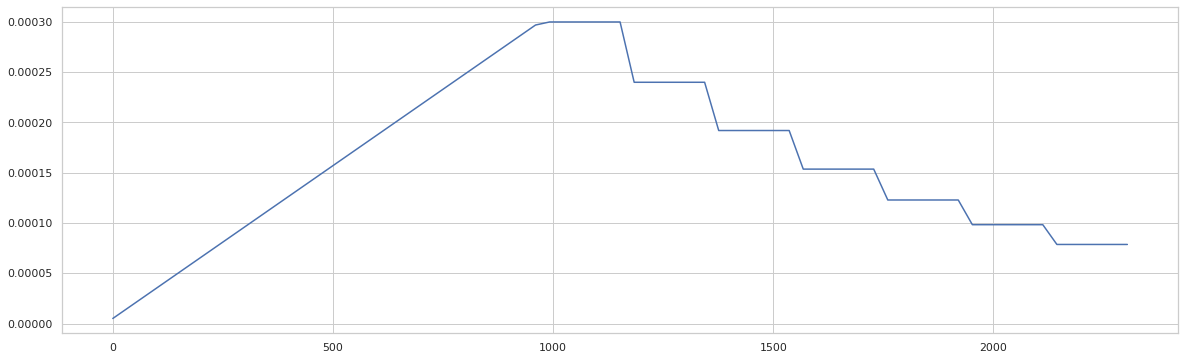

In [11]:
#@title
lr_min = 1e-6
lr_start = 5e-6
lr_max = config['LEARNING_RATE']
steps_per_epoch = 24844 // config['BATCH_SIZE']
total_steps = config['EPOCHS'] * steps_per_epoch
warmup_steps = steps_per_epoch * 5
hold_max_steps = 0
step_decay = .8
step_size = steps_per_epoch * 1

rng = [i for i in range(0, total_steps, 32)]
y = [step_schedule_with_warmup(tf.cast(x, tf.float32), step_size=step_size, 
                               warmup_steps=warmup_steps, hold_max_steps=hold_max_steps, 
                               lr_start=lr_start, lr_max=lr_max, step_decay=step_decay) for x in rng]

sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

# Model

In [12]:
# Initial bias
pos = len(k_fold[k_fold['target'] == 1])
neg = len(k_fold[k_fold['target'] == 0])
initial_bias = np.log([pos/neg])
print('Bias')
print(pos)
print(neg)
print(initial_bias)

# class weights
total = len(k_fold)
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}
print('Class weight')
print(class_weight)

Bias
584
32542
[-4.02038586]
Class weight
{0: 0.5089730194825148, 1: 28.36130136986301}


In [13]:
def model_fn(input_shape):
    input_image = L.Input(shape=input_shape, name='input_image')
    base_model = efn.EfficientNetB0(weights=config['BASE_MODEL_WEIGHTS'], 
                                    include_top=False)
    
    x = base_model(input_image)
    x = L.GlobalAveragePooling2D()(x)
    
    output = L.Dense(1, activation='sigmoid', name='output', 
                     bias_initializer=tf.keras.initializers.Constant(initial_bias))(x)
    
    model = Model(inputs=input_image, outputs=output)
    
    return model

# Training

In [14]:
# Evaluation
eval_dataset = get_eval_dataset(TRAINING_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
image_names = next(iter(eval_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(TRAINING_FILENAMES)))).numpy().astype('U')
image_data = eval_dataset.map(lambda data, label, image_name: data)
# Test
NUM_TEST_IMAGES = len(test)
test_preds = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_last = np.zeros((NUM_TEST_IMAGES, 1))
test_preds_tta_last = np.zeros((NUM_TEST_IMAGES, 1))

test_dataset = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
test_dataset_tta = get_test_dataset(TEST_FILENAMES, batch_size=config['BATCH_SIZE'], buffer_size=AUTO, tta=True)
image_names_test = next(iter(test_dataset.unbatch().map(lambda data, image_name: image_name).batch(NUM_TEST_IMAGES))).numpy().astype('U')
test_image_data = test_dataset.map(lambda data, image_name: data)
test_tta_image_data = test_dataset_tta.map(lambda data, image_name: data)


history_list = []
k_fold_best = k_fold.copy()
kfold = KFold(config['N_FOLDS'], shuffle=True, random_state=SEED)

for n_fold, (trn_idx, val_idx) in enumerate(kfold.split(TRAINING_FILENAMES)):
    if n_fold < config['N_USED_FOLDS']:
        n_fold +=1
        print('\nFOLD: %d' % (n_fold))
        tf.tpu.experimental.initialize_tpu_system(tpu)
        K.clear_session()

        ### Data
        train_filenames = np.array(TRAINING_FILENAMES)[trn_idx]
        valid_filenames = np.array(TRAINING_FILENAMES)[val_idx]
        steps_per_epoch  = count_data_items(train_filenames) // config['BATCH_SIZE']

        # Train model
        model_path = f'model_fold_{n_fold}.h5'

        es = EarlyStopping(monitor='val_auc', mode='max', patience=config['ES_PATIENCE'], 
                           restore_best_weights=False, verbose=1)
        checkpoint = ModelCheckpoint((MODEL_BASE_PATH + model_path), monitor='val_auc', mode='max', 
                                     save_best_only=True, save_weights_only=True)

        with strategy.scope():
            model = model_fn((config['HEIGHT'], config['WIDTH'], config['CHANNELS']))

            lr = lambda: step_schedule_with_warmup(tf.cast(optimizer.iterations, tf.float32), 
                                                   step_size=step_size, warmup_steps=warmup_steps, 
                                                   hold_max_steps=hold_max_steps, lr_start=lr_start, 
                                                   lr_max=lr_max, step_decay=step_decay)
        
            optimizer = optimizers.Adam(learning_rate=lr)
            model.compile(optimizer, loss=losses.BinaryCrossentropy(), 
                          metrics=[metrics.AUC()])

        history = model.fit(get_training_dataset(train_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            validation_data=get_validation_dataset(valid_filenames, ordered=True, repeated=False, 
                                                                   batch_size=config['BATCH_SIZE'], buffer_size=AUTO),
                            epochs=config['EPOCHS'], 
                            steps_per_epoch=steps_per_epoch ,
                            callbacks=[checkpoint, es],
                            class_weight=class_weight, 
                            verbose=2).history

        # save last epoch weights
        model.save_weights((MODEL_BASE_PATH + 'last_' + model_path))

        history_list.append(history)

        # Get validation IDs
        valid_dataset = get_eval_dataset(valid_filenames, batch_size=config['BATCH_SIZE'], buffer_size=AUTO)
        valid_image_names = next(iter(valid_dataset.unbatch().map(lambda data, label, image_name: image_name).batch(count_data_items(valid_filenames)))).numpy().astype('U')
        k_fold[f'fold_{n_fold}'] = k_fold.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        k_fold_best[f'fold_{n_fold}'] = k_fold_best.apply(lambda x: 'validation' if x['image_name'] in valid_image_names else 'train', axis=1)
        
        ##### Last model #####
        print('Last model evaluation...')
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold[f'pred_fold_{n_fold}'] = k_fold.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Last model inference...')
        test_preds_last += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (last) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta_last += model.predict(test_tta_image_data)

        ##### Best model #####
        print('Best model evaluation...')
        model.load_weights(MODEL_BASE_PATH + model_path)
        preds = model.predict(image_data)
        name_preds_eval = dict(zip(image_names, preds.reshape(len(preds))))
        k_fold_best[f'pred_fold_{n_fold}'] = k_fold_best.apply(lambda x: name_preds_eval[x['image_name']], axis=1)

        print('Best model inference...')
        test_preds += model.predict(test_image_data)

        # TTA preds
        print(f'Running TTA (best) {config["TTA_STEPS"]} steps...')
        for step in range(config['TTA_STEPS']):
            test_preds_tta += model.predict(test_tta_image_data)


# normalize preds
test_preds /= config['N_USED_FOLDS']
test_preds_tta /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])
test_preds_last /= config['N_USED_FOLDS']
test_preds_tta_last /= (config['N_USED_FOLDS'] * config['TTA_STEPS'])

name_preds = dict(zip(image_names_test, test_preds.reshape(NUM_TEST_IMAGES)))
name_preds_tta = dict(zip(image_names_test, test_preds_tta.reshape(NUM_TEST_IMAGES)))
name_preds_last = dict(zip(image_names_test, test_preds_last.reshape(NUM_TEST_IMAGES)))
name_preds_tta_last = dict(zip(image_names_test, test_preds_tta_last.reshape(NUM_TEST_IMAGES)))

test['target'] = test.apply(lambda x: name_preds[x['image_name']], axis=1)
test['target_tta'] = test.apply(lambda x: name_preds_tta[x['image_name']], axis=1)
test['target_last'] = test.apply(lambda x: name_preds_last[x['image_name']], axis=1)
test['target_tta_last'] = test.apply(lambda x: name_preds_tta_last[x['image_name']], axis=1)


FOLD: 1


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


16703488/16696600 [==============================] - 0s 0us/step
Epoch 1/12
194/194 - 37s - loss: 1.5629 - auc: 0.6606 - val_loss: 0.0811 - val_auc: 0.7323
Epoch 2/12
194/194 - 25s - loss: 0.5135 - auc: 0.8410 - val_loss: 0.2935 - val_auc: 0.8564
Epoch 3/12
194/194 - 25s - loss: 0.4330 - auc: 0.8787 - val_loss: 0.4507 - val_auc: 0.8774
Epoch 4/12
194/194 - 25s - loss: 0.4221 - auc: 0.8875 - val_loss: 0.3425 - val_auc: 0.8846
Epoch 5/12
194/194 - 23s - loss: 0.4225 - auc: 0.8842 - val_loss: 0.2851 - val_auc: 0.8726
Epoch 6/12
194/194 - 25s - loss: 0.3995 - auc: 0.8991 - val_loss: 0.2098 - val_auc: 0.8873
Epoch 7/12
194/194 - 23s - loss: 0.3698 - auc: 0.9126 - val_loss: 0.3579 - val_auc: 0.8836
Epoch 8/12
194/194 - 27s - loss: 0.3380 - auc: 0.9237 - val_loss: 0.2751 - val_auc: 0.8908
Epoch 9/12
194/194 - 25s - loss: 0.3096 - auc: 0.9421 - val_loss: 0.3014 - val_auc: 0.8967
Epoch 10/12
194/194 - 24s - loss: 0.2806 - auc: 0.9495 - val_loss: 0.2403 - val_auc: 0.8923
Epoch 11/12
194/194 - 24

INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 40s - loss: 1.5059 - auc: 0.6583 - val_loss: 0.1005 - val_auc: 0.7565
Epoch 2/12
210/210 - 26s - loss: 0.4998 - auc: 0.8429 - val_loss: 0.2468 - val_auc: 0.8746
Epoch 3/12
210/210 - 26s - loss: 0.4344 - auc: 0.8747 - val_loss: 0.2482 - val_auc: 0.8882
Epoch 4/12
210/210 - 24s - loss: 0.4246 - auc: 0.8807 - val_loss: 0.5387 - val_auc: 0.8650
Epoch 5/12
210/210 - 25s - loss: 0.4114 - auc: 0.8899 - val_loss: 0.3419 - val_auc: 0.8815
Epoch 6/12
210/210 - 27s - loss: 0.3938 - auc: 0.8972 - val_loss: 0.4190 - val_auc: 0.8985
Epoch 7/12
210/210 - 24s - loss: 0.3453 - auc: 0.9224 - val_loss: 0.2974 - val_auc: 0.8961
Epoch 8/12
210/210 - 24s - loss: 0.3136 - auc: 0.9357 - val_loss: 0.2091 - val_auc: 0.8971
Epoch 9/12
210/210 - 26s - loss: 0.3051 - auc: 0.9396 - val_loss: 0.2381 - val_auc: 0.9014
Epoch 10/12
210/210 - 27s - loss: 0.2820 - auc: 0.9471 - val_loss: 0.3169 - val_auc: 0.9044
Epoch 11/12
210/210 - 24s - loss: 0.2676 - auc: 0.9547 - val_loss: 0.2398 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - loss: 1.4351 - auc: 0.6410 - val_loss: 0.0906 - val_auc: 0.7831
Epoch 2/12
210/210 - 26s - loss: 0.4930 - auc: 0.8467 - val_loss: 0.3215 - val_auc: 0.8571
Epoch 3/12
210/210 - 26s - loss: 0.4513 - auc: 0.8658 - val_loss: 0.2816 - val_auc: 0.8701
Epoch 4/12
210/210 - 25s - loss: 0.4227 - auc: 0.8819 - val_loss: 0.2930 - val_auc: 0.8656
Epoch 5/12
210/210 - 27s - loss: 0.4145 - auc: 0.8875 - val_loss: 0.3707 - val_auc: 0.8887
Epoch 6/12
210/210 - 26s - loss: 0.3608 - auc: 0.9130 - val_loss: 0.7532 - val_auc: 0.8901
Epoch 7/12
210/210 - 26s - loss: 0.3402 - auc: 0.9246 - val_loss: 0.2799 - val_auc: 0.9060
Epoch 8/12
210/210 - 25s - loss: 0.3212 - auc: 0.9309 - val_loss: 0.2234 - val_auc: 0.9014
Epoch 9/12
210/210 - 26s - loss: 0.2925 - auc: 0.9451 - val_loss: 0.2305 - val_auc: 0.9115
Epoch 10/12
210/210 - 25s - loss: 0.2562 - auc: 0.9573 - val_loss: 0.2637 - val_auc: 0.9094
Epoch 11/12
210/210 - 27s - loss: 0.2351 - auc: 0.9633 - val_loss: 0.2677 - val_auc: 0.91

INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 37s - loss: 1.4765 - auc: 0.6433 - val_loss: 0.0884 - val_auc: 0.7248
Epoch 2/12
210/210 - 26s - loss: 0.5038 - auc: 0.8382 - val_loss: 0.2556 - val_auc: 0.8766
Epoch 3/12
210/210 - 25s - loss: 0.4438 - auc: 0.8701 - val_loss: 0.2934 - val_auc: 0.8633
Epoch 4/12
210/210 - 26s - loss: 0.4298 - auc: 0.8788 - val_loss: 0.2887 - val_auc: 0.8767
Epoch 5/12
210/210 - 26s - loss: 0.4133 - auc: 0.8891 - val_loss: 0.4057 - val_auc: 0.8744
Epoch 6/12
210/210 - 27s - loss: 0.3940 - auc: 0.8990 - val_loss: 0.3804 - val_auc: 0.8784
Epoch 7/12
210/210 - 25s - loss: 0.3423 - auc: 0.9220 - val_loss: 0.1936 - val_auc: 0.8762
Epoch 8/12
210/210 - 27s - loss: 0.3459 - auc: 0.9229 - val_loss: 0.3294 - val_auc: 0.9093
Epoch 9/12
210/210 - 25s - loss: 0.3031 - auc: 0.9412 - val_loss: 0.4781 - val_auc: 0.9020
Epoch 10/12
210/210 - 25s - loss: 0.2699 - auc: 0.9535 - val_loss: 0.2035 - val_auc: 0.9051
Epoch 11/12
210/210 - 25s - loss: 0.2712 - auc: 0.9532 - val_loss: 0.2532 - val_auc: 0.90

INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.36.225.170:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


Epoch 1/12
210/210 - 39s - loss: 1.5698 - auc: 0.6179 - val_loss: 0.1044 - val_auc: 0.8181
Epoch 2/12
210/210 - 26s - loss: 0.5138 - auc: 0.8366 - val_loss: 0.3283 - val_auc: 0.8791
Epoch 3/12
210/210 - 27s - loss: 0.4562 - auc: 0.8627 - val_loss: 0.3674 - val_auc: 0.8952
Epoch 4/12
210/210 - 26s - loss: 0.4375 - auc: 0.8761 - val_loss: 0.3715 - val_auc: 0.8998
Epoch 5/12
210/210 - 28s - loss: 0.4121 - auc: 0.8890 - val_loss: 0.5148 - val_auc: 0.9006
Epoch 6/12
210/210 - 26s - loss: 0.3880 - auc: 0.9005 - val_loss: 0.3150 - val_auc: 0.9064
Epoch 7/12
210/210 - 25s - loss: 0.3600 - auc: 0.9174 - val_loss: 0.3403 - val_auc: 0.9048
Epoch 8/12
210/210 - 27s - loss: 0.3236 - auc: 0.9332 - val_loss: 0.2379 - val_auc: 0.9070
Epoch 9/12
210/210 - 29s - loss: 0.2996 - auc: 0.9425 - val_loss: 0.1850 - val_auc: 0.9162
Epoch 10/12
210/210 - 27s - loss: 0.2676 - auc: 0.9532 - val_loss: 0.1889 - val_auc: 0.9175
Epoch 11/12
210/210 - 25s - loss: 0.2571 - auc: 0.9576 - val_loss: 0.2359 - val_auc: 0.91

## Model loss graph

Fold: 1


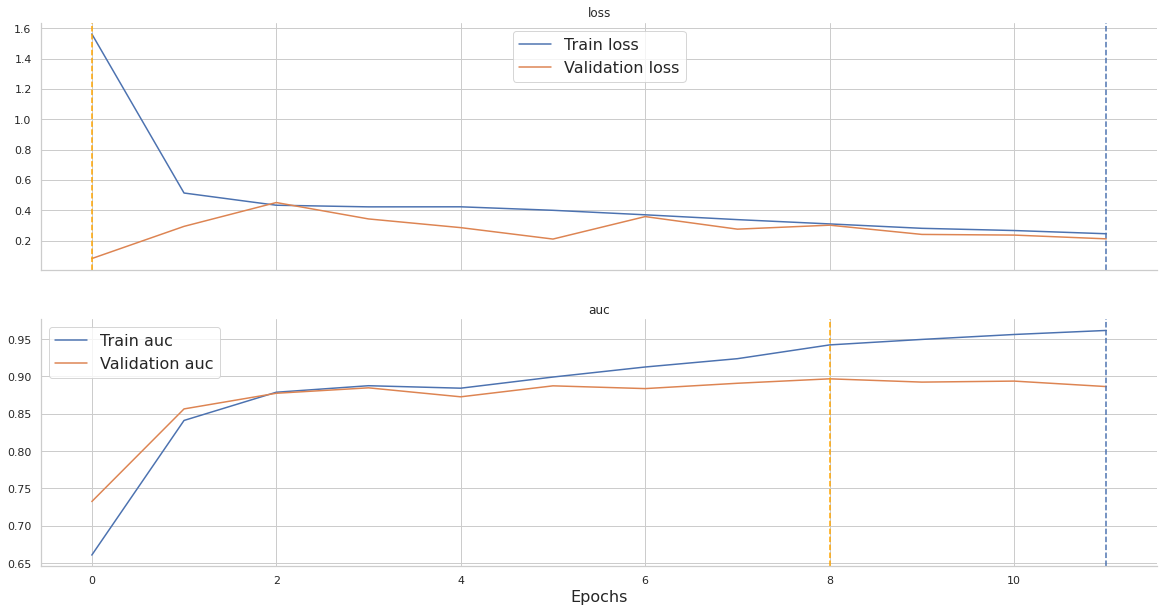

Fold: 2


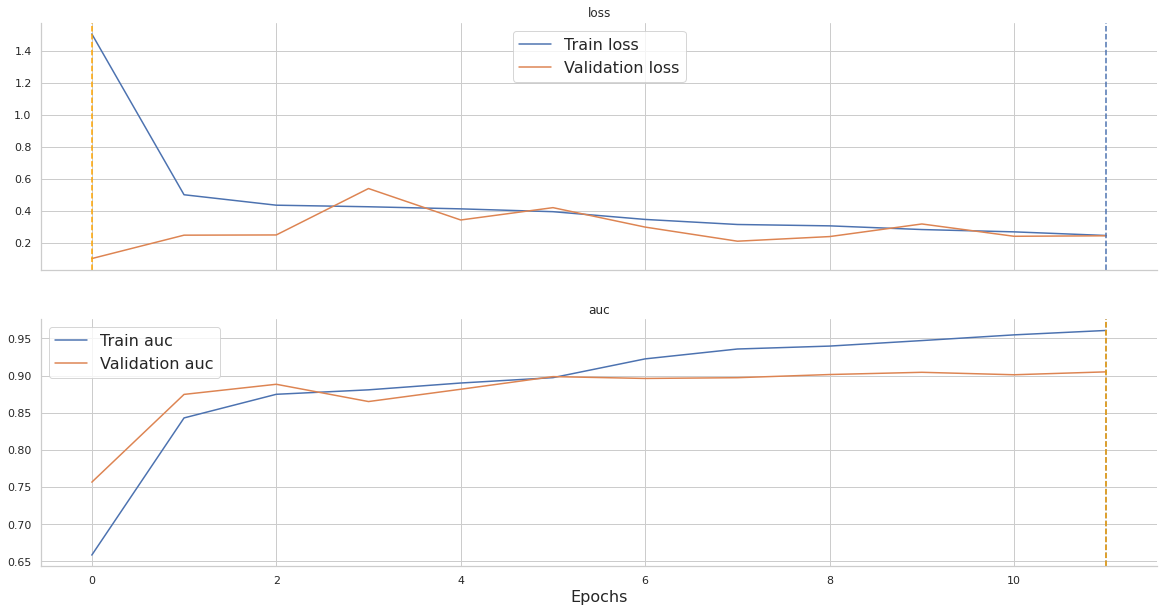

Fold: 3


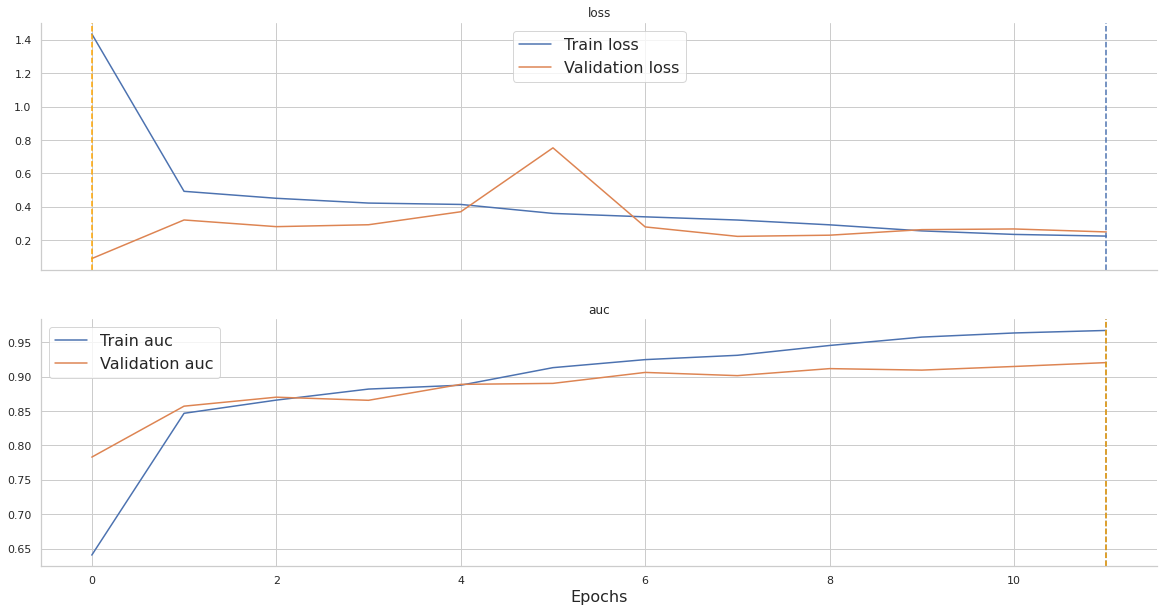

Fold: 4


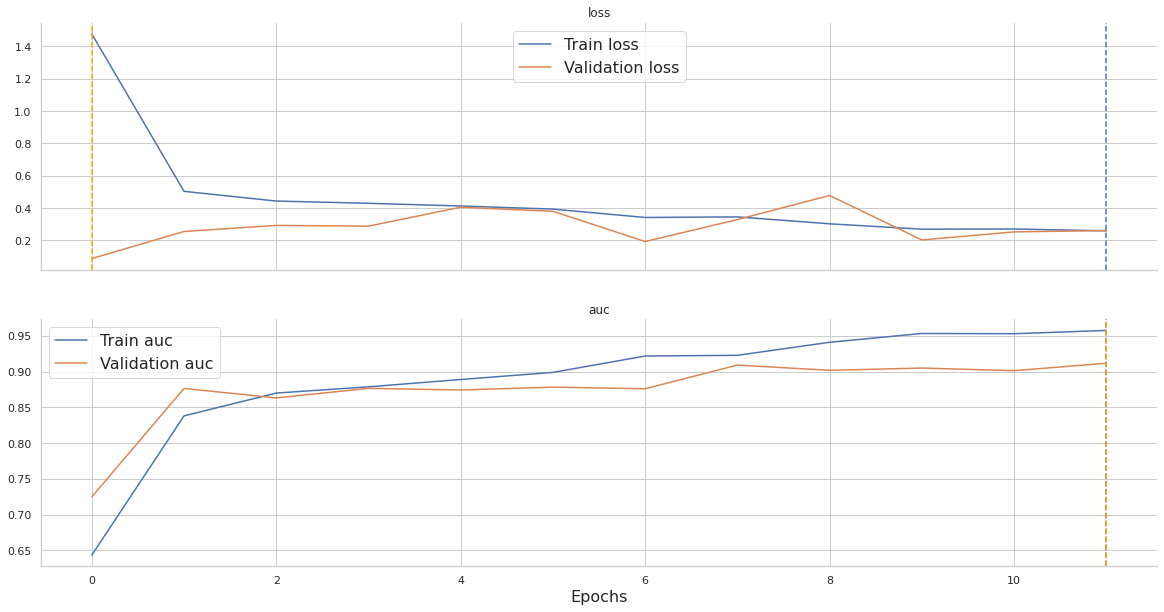

Fold: 5


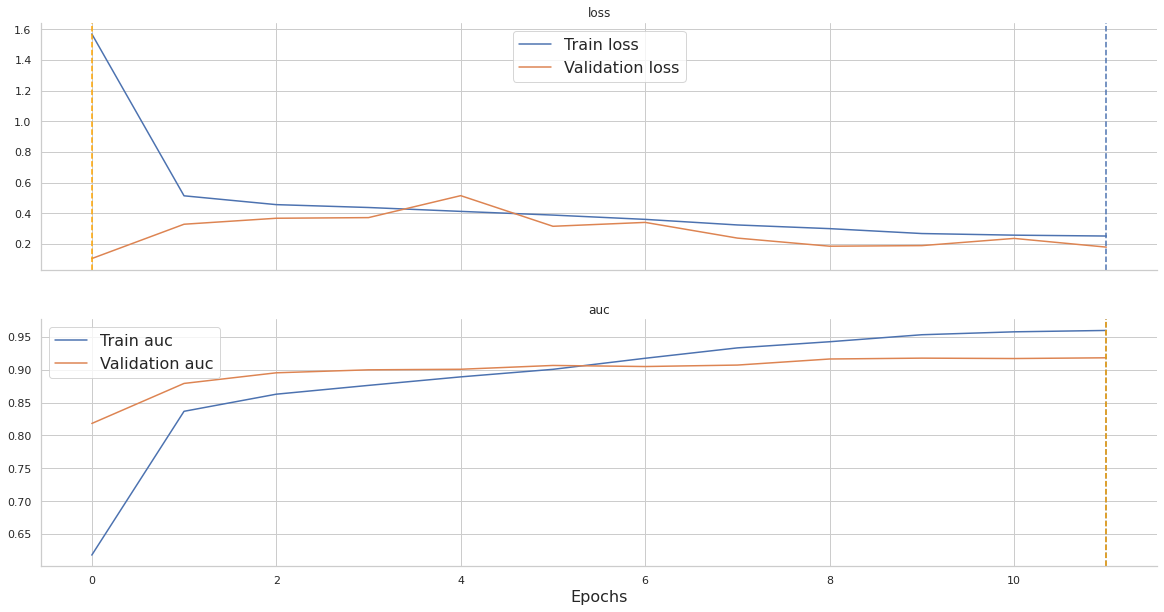

In [15]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    print(f'Fold: {n_fold + 1}')
    plot_metrics(history_list[n_fold])

## Model loss graph aggregated

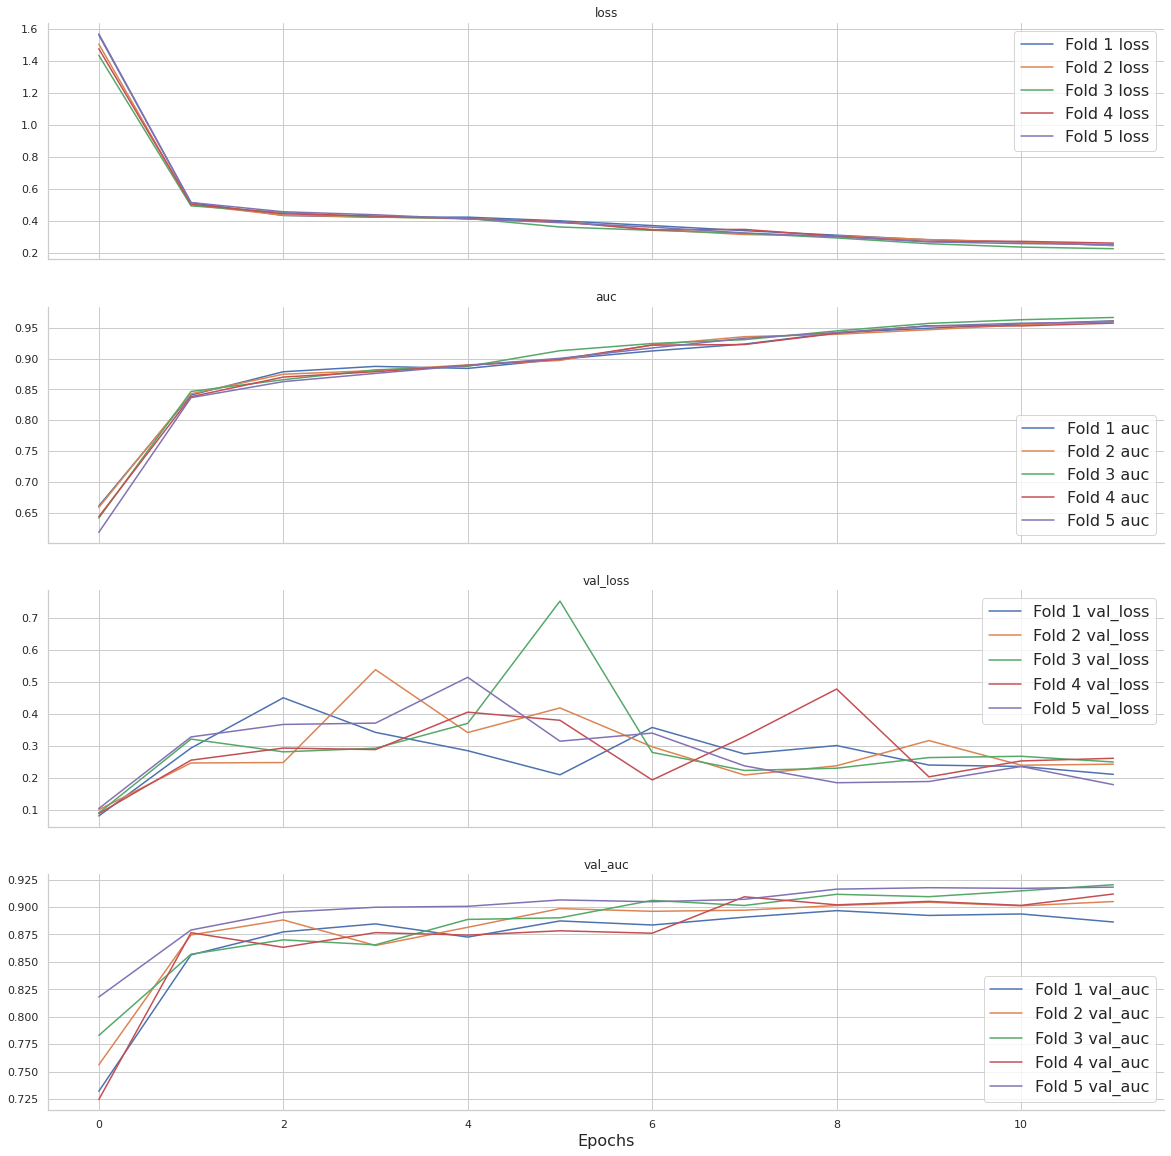

In [16]:
#@title
plot_metrics_agg(history_list, config['N_USED_FOLDS'])

# Model evaluation (last)

In [17]:
#@title
display(evaluate_model(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.987447,0.909283,0.078163,0.987406,0.889727,0.987663,0.905045,0.991838,0.920527,0.983882,0.912734,0.986445,0.918384
Accuracy,0.916159,0.904518,0.011640,0.932332,0.915017,0.910452,0.895864,0.915357,0.901658,0.893994,0.886507,0.928659,0.923547
Precision,0.174987,0.116575,0.058412,0.205238,0.113855,0.163187,0.105727,0.170856,0.122727,0.139528,0.101078,0.196128,0.139489
Recall,0.982761,0.657412,0.325348,0.972912,0.588652,0.989451,0.654545,0.995754,0.716814,0.976695,0.669643,0.978992,0.657407
F1-score,0.296353,0.197643,0.098710,0.338970,0.190805,0.280167,0.182048,0.291667,0.209573,0.244174,0.175644,0.326788,0.230146
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.987447,0.909283,0.078163,0.987406,0.889727,0.987663,0.905045,0.991838,0.920527,0.983882,0.912734,0.986445,0.918384
male,0.987054,0.913667,0.073388,0.986699,0.901488,0.987948,0.893228,0.991082,0.939709,0.983127,0.912582,0.986415,0.921326
female,0.987333,0.900032,0.087301,0.987770,0.870708,0.986959,0.923113,0.992492,0.880558,0.983815,0.911840,0.985628,0.913938
head/neck,0.977974,0.869247,0.108727,0.978096,0.912558,0.977931,0.826597,0.976498,0.880495,0.982819,0.852601,0.974524,0.873984
upper extremity,0.987985,0.909747,0.078238,0.987800,0.873432,0.986242,0.920088,0.993612,0.911554,0.984117,0.929089,0.988156,0.914572
lower extremity,0.988337,0.885268,0.103069,0.990811,0.842143,0.989840,0.875030,0.992434,0.926020,0.980505,0.929847,0.988093,0.853299
torso,0.987676,0.923993,0.063683,0.986892,0.911257,0.987680,0.936209,0.992755,0.920427,0.984895,0.909818,0.986158,0.942256
0 <= age < 26,0.984158,0.871528,0.112630,0.986017,0.859441,0.986464,0.805104,0.992169,0.910072,0.976051,0.873799,0.980091,0.909226
26 <= age < 40,0.991149,0.921859,0.069290,0.989518,0.948425,0.990435,0.850687,0.995136,0.954311,0.990210,0.902881,0.990445,0.952991


# Model evaluation (best)

In [18]:
#@title
display(evaluate_model(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))
display(evaluate_model_Subset(k_fold_best, config['N_USED_FOLDS']).style.applymap(color_map))

,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Metric,,,,,,,,,,,,,
ROC AUC,0.985234,0.910786,0.074448,0.975984,0.896607,0.987714,0.905376,0.991891,0.920647,0.983924,0.912296,0.986654,0.919004
Accuracy,0.907589,0.897067,0.010523,0.888294,0.875664,0.910564,0.896024,0.916583,0.903106,0.893808,0.887151,0.928696,0.923386
Precision,0.161073,0.112620,0.048453,0.134253,0.094804,0.163123,0.105882,0.172935,0.124424,0.139099,0.101626,0.195954,0.136364
Recall,0.980140,0.683496,0.296644,0.966140,0.737589,0.987342,0.654545,0.995754,0.716814,0.974576,0.669643,0.976891,0.638889
F1-score,0.276061,0.192712,0.083350,0.235748,0.168013,0.279988,0.182278,0.294691,0.212042,0.243451,0.176471,0.326430,0.224756
Support,467.200000,116.800000,350.400000,443.000000,141.000000,474.000000,110.000000,471.000000,113.000000,472.000000,112.000000,476.000000,108.000000


,Train,Valid,Var,Train_fold_1,Valid_fold_1,Train_fold_2,Valid_fold_2,Train_fold_3,Valid_fold_3,Train_fold_4,Valid_fold_4,Train_fold_5,Valid_fold_5
Subset/ROC AUC,,,,,,,,,,,,,
Overall,0.985234,0.910786,0.074448,0.975984,0.896607,0.987714,0.905376,0.991891,0.920647,0.983924,0.912296,0.986654,0.919004
male,0.984923,0.915560,0.069363,0.975920,0.911352,0.987929,0.893802,0.991181,0.939440,0.983124,0.912033,0.986459,0.921172
female,0.984880,0.901162,0.083718,0.974768,0.873993,0.987148,0.923286,0.992492,0.881168,0.983904,0.911628,0.986090,0.915736
head/neck,0.973364,0.866183,0.107181,0.954300,0.895116,0.978127,0.830074,0.976648,0.881115,0.983111,0.849863,0.974635,0.874746
upper extremity,0.985785,0.912716,0.073069,0.976751,0.887921,0.986198,0.918761,0.993646,0.912851,0.983924,0.930032,0.988408,0.914016
lower extremity,0.986622,0.887890,0.098733,0.982278,0.851087,0.989820,0.876246,0.992460,0.925921,0.980198,0.930146,0.988353,0.856047
torso,0.985634,0.925273,0.060361,0.976033,0.917572,0.987793,0.935985,0.992822,0.920362,0.985135,0.909271,0.986386,0.943173
0 <= age < 26,0.981801,0.870369,0.111432,0.974074,0.845455,0.986359,0.814965,0.992483,0.907674,0.975938,0.871179,0.980150,0.912574
26 <= age < 40,0.987538,0.922811,0.064727,0.971289,0.953506,0.990721,0.850436,0.994998,0.953843,0.990309,0.903277,0.990374,0.952991


# Confusion matrix

Fold: 1


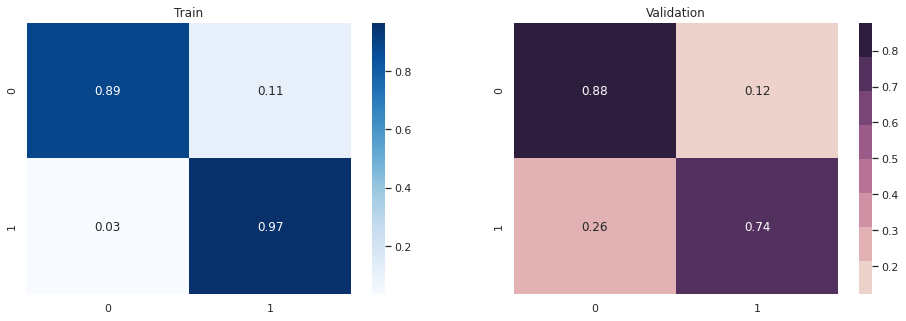

Fold: 2


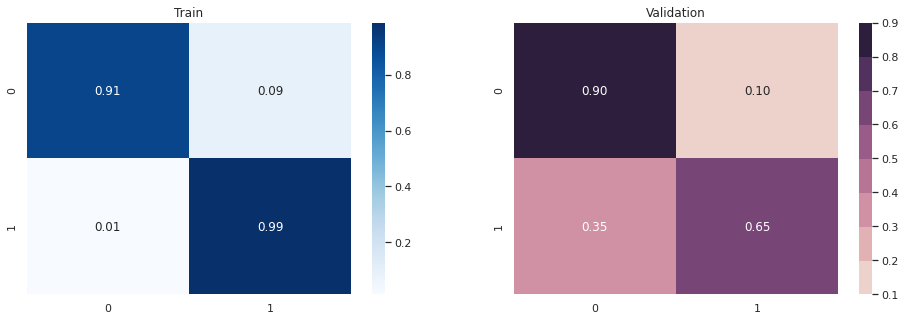

Fold: 3


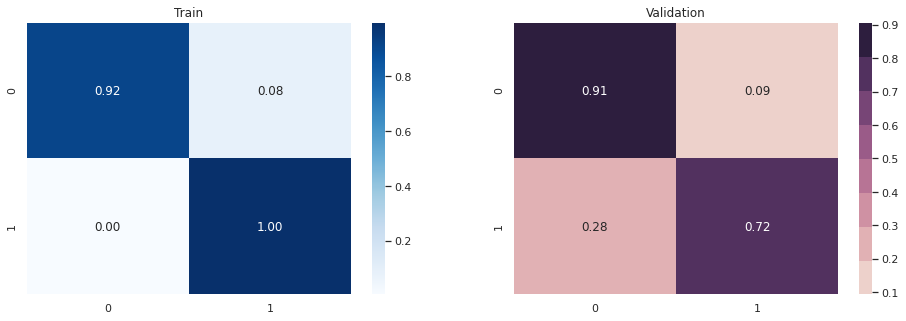

Fold: 4


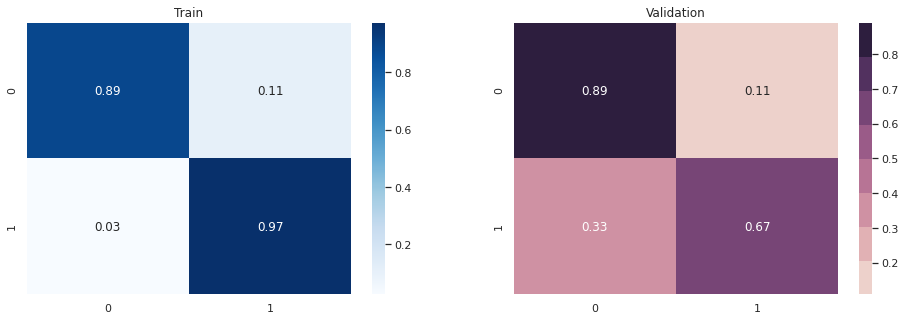

Fold: 5


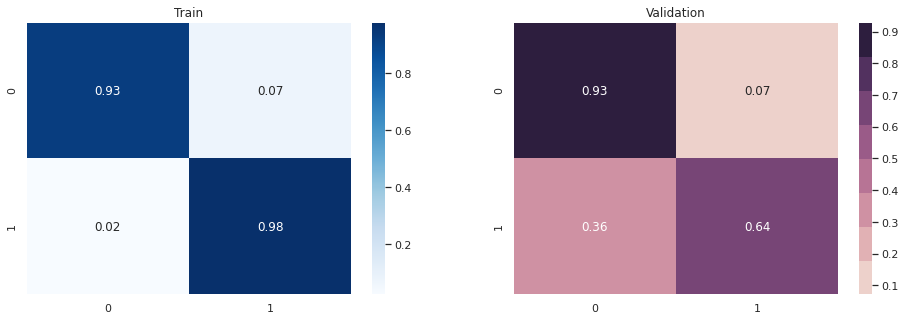

In [19]:
#@title
for n_fold in range(config['N_USED_FOLDS']):
    n_fold += 1
    pred_col = f'pred_fold_{n_fold}' 
    train_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'train']
    valid_set = k_fold_best[k_fold_best[f'fold_{n_fold}'] == 'validation'] 
    print(f'Fold: {n_fold}')
    plot_confusion_matrix(train_set['target'], np.round(train_set[pred_col]),
                          valid_set['target'], np.round(valid_set[pred_col]))

# Visualize predictions

In [20]:
#@title
k_fold['pred'] = 0
for n_fold in range(config['N_USED_FOLDS']):
    k_fold['pred'] += k_fold[f'pred_fold_{n_fold+1}'] / config['N_FOLDS']

print('Label/prediction distribution')
print(f"Train positive labels: {len(k_fold[k_fold['target'] > .5])}")
print(f"Train positive predictions: {len(k_fold[k_fold['pred'] > .5])}")
print(f"Train positive correct predictions: {len(k_fold[(k_fold['target'] > .5) & (k_fold['pred'] > .5)])}")
    
print('Top 10 samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('target == 1').head(10))


print('Top 10 predicted positive samples')
display(k_fold[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'diagnosis',
                'target', 'pred'] + [c for c in k_fold.columns if (c.startswith('pred_fold'))]].query('pred > .5').head(10))

Label/prediction distribution
Train positive labels: 584
Train positive predictions: 2918
Train positive correct predictions: 577
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
0,ISIC_2637011,male,45.0,head/neck,unknown,0,0.090563,0.218659,0.020047,0.027869,0.086280,0.099961
1,ISIC_0015719,female,45.0,upper extremity,unknown,0,0.001334,0.001071,0.000969,0.000273,0.000717,0.003642
2,ISIC_0052212,female,50.0,lower extremity,nevus,0,0.002912,0.004742,0.001481,0.000961,0.004668,0.002707
3,ISIC_0068279,female,45.0,head/neck,unknown,0,0.112619,0.183247,0.069387,0.033886,0.061399,0.215178
4,ISIC_0074268,female,55.0,upper extremity,unknown,0,0.000397,0.000713,0.000331,0.000142,0.000377,0.000421
5,ISIC_0074311,female,40.0,lower extremity,unknown,0,0.002367,0.005838,0.000358,0.000600,0.001436,0.003602
6,ISIC_0074542,male,25.0,lower extremity,unknown,0,0.010594,0.025555,0.003859,0.017140,0.000690,0.005728
7,ISIC_0075663,female,35.0,torso,unknown,0,0.013451,0.017626,0.004655,0.003849,0.013081,0.028044
8,ISIC_0075914,male,30.0,torso,unknown,0,0.004561,0.002124,0.007248,0.000508,0.007486,0.005439
9,ISIC_0076262,female,50.0,lower extremity,unknown,0,0.011709,0.002306,0.043125,0.002443,0.006172,0.004498


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.794738,0.002595,0.986286,0.995684,0.992212,0.996912
235,ISIC_0188432,female,50.0,upper extremity,melanoma,1,0.889855,0.511634,0.985267,0.999764,0.993715,0.958892
314,ISIC_0207268,male,55.0,torso,melanoma,1,0.832080,0.997106,0.863235,0.363015,0.999136,0.937911
399,ISIC_0232101,male,65.0,torso,melanoma,1,0.729295,0.239553,0.952498,0.961146,0.757238,0.736040
459,ISIC_0247330,female,65.0,lower extremity,melanoma,1,0.906708,0.708768,0.964008,0.991316,0.967347,0.902100
475,ISIC_0250839,male,75.0,head/neck,melanoma,1,0.983808,0.968386,0.996465,0.983899,0.971524,0.998764
544,ISIC_0272509,female,35.0,lower extremity,melanoma,1,0.975004,0.992422,0.894290,0.992166,0.997764,0.998379
546,ISIC_0273046,male,80.0,torso,melanoma,1,0.734876,0.296511,0.934892,0.996014,0.650124,0.796840
551,ISIC_0274382,male,65.0,torso,melanoma,1,0.787709,0.350960,0.880770,0.952328,0.907684,0.846805
558,ISIC_0275828,male,30.0,lower extremity,melanoma,1,0.923480,0.985850,0.974974,0.721409,0.998528,0.936638


Top 10 predicted positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,diagnosis,target,pred,pred_fold_1,pred_fold_2,pred_fold_3,pred_fold_4,pred_fold_5
10,ISIC_0076545,male,55.0,upper extremity,unknown,0,0.742273,0.941540,0.823550,0.657937,0.690552,0.597783
20,ISIC_0080817,male,50.0,lower extremity,unknown,0,0.549165,0.210160,0.503884,0.462642,0.680938,0.888199
48,ISIC_0092870,male,55.0,torso,unknown,0,0.594452,0.987755,0.830465,0.452681,0.548409,0.152950
91,ISIC_0149568,female,55.0,upper extremity,melanoma,1,0.794738,0.002595,0.986286,0.995684,0.992212,0.996912
110,ISIC_0154880,male,75.0,torso,unknown,0,0.527618,0.127156,0.780629,0.970370,0.719507,0.040429
111,ISIC_0155012,male,55.0,torso,nevus,0,0.644540,0.579022,0.588209,0.793163,0.641921,0.620387
117,ISIC_0156642,female,40.0,torso,nevus,0,0.550975,0.712693,0.892216,0.276557,0.576138,0.297270
123,ISIC_0159060,male,55.0,head/neck,unknown,0,0.644114,0.203047,0.681566,0.892653,0.529327,0.913979
128,ISIC_0159996,female,60.0,head/neck,unknown,0,0.909683,0.754037,0.945570,0.916631,0.972098,0.960080
151,ISIC_0165449,male,60.0,torso,unknown,0,0.547113,0.397709,0.862795,0.929999,0.447154,0.097908


# Visualize test predictions

In [21]:
#@title
print(f"Test predictions {len(test[test['target'] > .5])}|{len(test[test['target'] <= .5])}")
print(f"Test predictions (last) {len(test[test['target_last'] > .5])}|{len(test[test['target_last'] <= .5])}")
print(f"Test predictions (tta) {len(test[test['target_tta'] > .5])}|{len(test[test['target_tta'] <= .5])}")
print(f"Test predictions (last tta) {len(test[test['target_tta_last'] > .5])}|{len(test[test['target_tta_last'] <= .5])}")

print('Top 10 samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].head(10))

print('Top 10 positive samples')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target > .5').head(10))

print('Top 10 positive samples (last)')
display(test[['image_name', 'sex', 'age_approx','anatom_site_general_challenge', 'target', 'target_last', 
              'target_tta', 'target_tta_last'] + [c for c in test.columns if (c.startswith('pred_fold'))]].query('target_last > .5').head(10))

Test predictions 1285|9697
Test predictions (last) 1175|9807
Test predictions (tta) 1259|9723
Test predictions (last tta) 1171|9811
Top 10 samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
0,ISIC_0052060,male,70.0,NaN,0.000784,0.000598,0.002675,0.001331
1,ISIC_0052349,male,40.0,lower extremity,0.000323,0.000354,0.000638,0.000693
2,ISIC_0058510,female,55.0,torso,0.000191,0.000176,0.001595,0.001271
3,ISIC_0073313,female,50.0,torso,0.000617,0.000563,0.000703,0.000656
4,ISIC_0073502,female,45.0,lower extremity,0.191675,0.151382,0.146287,0.150873
5,ISIC_0074618,male,50.0,lower extremity,0.020776,0.013066,0.022291,0.019084
6,ISIC_0076801,male,45.0,upper extremity,0.026452,0.019172,0.119903,0.099223
7,ISIC_0077586,male,50.0,lower extremity,0.322912,0.302635,0.257824,0.254033
8,ISIC_0082004,female,45.0,torso,0.122738,0.123120,0.122461,0.130771
9,ISIC_0082785,male,65.0,lower extremity,0.034423,0.015225,0.065757,0.035550


Top 10 positive samples


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
19,ISIC_0099348,female,45.0,upper extremity,0.633346,0.575510,0.591077,0.550690
22,ISIC_0105104,male,40.0,torso,0.759327,0.795036,0.501197,0.557111
24,ISIC_0112420,female,65.0,torso,0.857496,0.805880,0.875518,0.889788
42,ISIC_0155983,male,70.0,torso,0.915572,0.911243,0.922573,0.887976
45,ISIC_0161963,male,35.0,upper extremity,0.606411,0.629876,0.601246,0.650883
56,ISIC_0169906,male,85.0,torso,0.587147,0.540775,0.573956,0.541222
57,ISIC_0171865,male,65.0,palms/soles,0.794824,0.747569,0.783898,0.755918
61,ISIC_0175798,female,55.0,torso,0.703923,0.597680,0.795323,0.708767
64,ISIC_0178235,female,70.0,lower extremity,0.695089,0.674710,0.545347,0.553170
69,ISIC_0182213,female,80.0,head/neck,0.675117,0.665023,0.693710,0.652553


Top 10 positive samples (last)


,image_name,sex,age_approx,anatom_site_general_challenge,target,target_last,target_tta,target_tta_last
19,ISIC_0099348,female,45.0,upper extremity,0.633346,0.575510,0.591077,0.550690
22,ISIC_0105104,male,40.0,torso,0.759327,0.795036,0.501197,0.557111
24,ISIC_0112420,female,65.0,torso,0.857496,0.805880,0.875518,0.889788
42,ISIC_0155983,male,70.0,torso,0.915572,0.911243,0.922573,0.887976
45,ISIC_0161963,male,35.0,upper extremity,0.606411,0.629876,0.601246,0.650883
56,ISIC_0169906,male,85.0,torso,0.587147,0.540775,0.573956,0.541222
57,ISIC_0171865,male,65.0,palms/soles,0.794824,0.747569,0.783898,0.755918
61,ISIC_0175798,female,55.0,torso,0.703923,0.597680,0.795323,0.708767
64,ISIC_0178235,female,70.0,lower extremity,0.695089,0.674710,0.545347,0.553170
69,ISIC_0182213,female,80.0,head/neck,0.675117,0.665023,0.693710,0.652553


# Test set predictions

In [22]:
#@title
submission = pd.read_csv(database_base_path + 'sample_submission.csv')
submission['target'] = test['target']
submission['target_last'] = test['target_last']
submission['target_blend'] = (test['target'] * .5) +  (test['target_last'] * .5)
submission['target_tta'] = test['target_tta']
submission['target_tta_last'] = test['target_tta_last']
submission['target_tta_blend'] = (test['target_tta'] * .5) +  (test['target_tta_last'] * .5)
display(submission.head(10))
display(submission.describe())

### BEST ###
submission[['image_name', 'target']].to_csv(SUBMISSION_PATH, index=False)

### LAST ###
submission_last = submission[['image_name', 'target_last']]
submission_last.columns = ['image_name', 'target']
submission_last.to_csv(SUBMISSION_LAST_PATH, index=False)

### BLEND ###
submission_blend = submission[['image_name', 'target_blend']]
submission_blend.columns = ['image_name', 'target']
submission_blend.to_csv(SUBMISSION_BLEND_PATH, index=False)

### TTA ###
submission_tta = submission[['image_name', 'target_tta']]
submission_tta.columns = ['image_name', 'target']
submission_tta.to_csv(SUBMISSION_TTA_PATH, index=False)

### TTA LAST ###
submission_tta_last = submission[['image_name', 'target_tta_last']]
submission_tta_last.columns = ['image_name', 'target']
submission_tta_last.to_csv(SUBMISSION_TTA_LAST_PATH, index=False)

### TTA BLEND ###
submission_blend_tta = submission[['image_name', 'target_tta_blend']]
submission_blend_tta.columns = ['image_name', 'target']
submission_blend_tta.to_csv(SUBMISSION_TTA_BLEND_PATH, index=False)

,image_name,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
0,ISIC_0052060,0.000784,0.000598,0.000691,0.002675,0.001331,0.002003
1,ISIC_0052349,0.000323,0.000354,0.000339,0.000638,0.000693,0.000666
2,ISIC_0058510,0.000191,0.000176,0.000184,0.001595,0.001271,0.001433
3,ISIC_0073313,0.000617,0.000563,0.000590,0.000703,0.000656,0.000679
4,ISIC_0073502,0.191675,0.151382,0.171528,0.146287,0.150873,0.148580
5,ISIC_0074618,0.020776,0.013066,0.016921,0.022291,0.019084,0.020687
6,ISIC_0076801,0.026452,0.019172,0.022812,0.119903,0.099223,0.109563
7,ISIC_0077586,0.322912,0.302635,0.312774,0.257824,0.254033,0.255929
8,ISIC_0082004,0.122738,0.123120,0.122929,0.122461,0.130771,0.126616
9,ISIC_0082785,0.034423,0.015225,0.024824,0.065757,0.035550,0.050654


,target,target_last,target_blend,target_tta,target_tta_last,target_tta_blend
count,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000,10982.000000
mean,0.164087,0.153633,0.158860,0.168990,0.159618,0.164304
std,0.238687,0.233255,0.235674,0.234317,0.229975,0.231873
min,0.000041,0.000031,0.000038,0.000112,0.000092,0.000112
25%,0.004799,0.003968,0.004415,0.007406,0.006188,0.006847
50%,0.044706,0.036012,0.041080,0.055332,0.045478,0.050952
75%,0.224464,0.202017,0.213895,0.239331,0.221159,0.228555
max,0.998417,0.998077,0.998247,0.998936,0.998568,0.998752
